# Data labeling tool for evaluating tsdr accuracy

In [300]:
%reload_ext autoreload
%autoreload 2

In [301]:
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

In [302]:
import sys
sys.path.append('../')
from tsdr import tsdr
from eval import groundtruth
from meltria import loader

In [303]:
from notebooklib.save import load_tsdr

DATASET_ID = "qknmc"
datasets = load_tsdr(DATASET_ID)

In [304]:
well_injected_fault_dataset_entries_texts: list[str] = """
carts/pod-cpu-hog/0
carts-db/pod-memory-hog/0
payment/pod-cpu-hog/0
user/pod-cpu-hog/0
catalogue-db/pod-memory-hog/0
catalogue/pod-cpu-hog/0
orders/pod-network-loss/0
orders/pod-cpu-hog/0
catalogue-db/pod-cpu-hog/0
user-db/pod-memory-hog/0
orders/pod-memory-hog/0
carts-db/pod-cpu-hog/0
orders-db/pod-cpu-hog/0
orders-db/pod-network-loss/0
orders-db/pod-memory-hog/0
user/pod-network-loss/0
payment/pod-network-loss/0
catalogue/pod-network-loss/0
catalogue-db/pod-network-loss/0
payment/pod-memory-hog/0
front-end/pod-memory-hog/0
user/pod-memory-hog/0
user-db/pod-cpu-hog/0
catalogue/pod-memory-hog/0
carts/pod-network-loss/0
front-end/pod-cpu-hog/0
carts-db/pod-network-loss/0
carts/pod-memory-hog/0
user-db/pod-network-loss/0
""".splitlines()
well_injected_fault_dataset_entries: list[tuple[str, str]] = [
    tuple(line.rstrip("/0").split("/")) for line in well_injected_fault_dataset_entries_texts
][1:]

well_injected_fault_datasets = [
    (record, filtered_df, anomalous_df, reduced_df) 
    for record, filtered_df, anomalous_df, reduced_df in datasets 
    if (record.chaos_comp(), record.chaos_type()) in well_injected_fault_dataset_entries
]

In [305]:
import random

# NUM_SAMPLES_BY_CHAOS_TYPE = 5

samples_by_chaos_type: dict = defaultdict(list)
for record, filtered_df, _, _ in random.sample(well_injected_fault_datasets, k=len(well_injected_fault_datasets)):
    gt_candidates = groundtruth.select_ground_truth_metrics_in_routes(
        record.pk, filtered_df.columns.to_list(), record.chaos_type(), record.chaos_comp(), gt_opts={
            "cause_middleware": True,
            "cause_service": True,
            "neighbors_in_cause_service": True,
            "propagated_route": True,
        }
    )
    # flatten and unique to remove duplicates
    gt_metrics = list(set([metric for metrics, _ in gt_candidates for metric in metrics]))

    samples_by_chaos_type[record.chaos_type()].append((record, filtered_df[gt_metrics]))

record_and_faulty_metrics_df = []
for chaos_type, samples in samples_by_chaos_type.items():
    record_and_faulty_metrics_df.extend(samples)

In [306]:
from typing import Callable

from tslearn.metrics import dtw

from tsdr.clustering.sbd import sbd

def find_similar_metrics(X: pd.DataFrame, col: str, k: int = 5, method="dtw") -> tuple[pd.DataFrame, pd.Series]:
    base_x = X.loc[:, col].to_numpy()
    _X: pd.DataFrame = X.loc[:, X.columns!=col]
    dist_func: Callable
    match method:
        case "dtw":
            dist_func = dtw
        case "sbd":
            dist_func = sbd
        case _:
            raise ValueError(f"Unknown method: {method}")
    topk = _X.agg(lambda y: dist_func(base_x, y.to_numpy())).T.sort_values().head(k)
    return _X[topk.index], topk


In [317]:
from dataclasses import dataclass

@dataclass(frozen=True)
class TSWindow:
    total_records: int
    current_record_no: int
    record: loader.DatasetRecord
    total_metrics_in_current_record: int
    current_metrics_no_in_current_record: int
    current_metric: str
    current_metric_ts: np.ndarray
    sli_metric_ts: np.ndarray
    sli_metric: str
    similar_metrics_df: pd.DataFrame
    similar_metrics_top_score: pd.Series
    progress_stats: pd.DataFrame
    
    def current_pos_info(self) -> str:
        return f"{self.current_record_no}/{self.total_records}:{self.record.chaos_case_full()} -> {self.current_metrics_no_in_current_record}/{self.total_metrics_in_current_record}"

In [316]:
import ipywidgets as widgets

def create_widget_for_clustering(yield_on_click, num_similar_metrics: int = 10) -> widgets.Box:
    save_button = widgets.Button(description='Save')
    skip_button = widgets.Button(description='Skip')
    skip_record_button = widgets.Button(description='Skip Record')
    select_pattern = widgets.Select(
        options=[
            'Sudden increase', 'Sudden decrease', 'Level shift up', 'Level shift down', 
            'Steady increase', 'Steady decrease', 'Single spike', 'Single dip',
            'Transient level shift up', 'Transient level shift down', 'Multiple spikes', 'Multiple dips', 'Fluctuations',
            'White noise', 'Other normal',
        ],
        rows=15,
        layout=widgets.Layout(width='20%'),
    )
    select_position = widgets.Select(
        options=["no_anomaly", "anomaly_during_fault", "anomaly_outside_fault"],
        layout=widgets.Layout(width='15%'),
    )
    select_similar_metrics = widgets.SelectMultiple(
        options=[],
        rows=num_similar_metrics+2,
        disabled=False,
        layout=widgets.Layout(width='40%'),
    )
    msg_output = widgets.Output(layout={'border': '1px solid black'})
    fig_output = widgets.Output(layout={'border': '1px solid black'})
    log_output = widgets.Output(layout={'border': '1px solid black'})

    plt.rcParams["font.size"] = 6
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    fig1, cur_and_sli_axs = plt.subplots(1, 2, figsize=(8, 1.5), clear=True)
    fig2, similar_axs = plt.subplots(2, num_similar_metrics//2, figsize=(20, 5), clear=True)

    def show(tsw: TSWindow) -> None:
        with msg_output:
            msg_output.clear_output(wait=True)
            display(tsw.current_pos_info())

        cur_ax, sli_ax = cur_and_sli_axs[0], cur_and_sli_axs[1]
        cur_ax.clear()
        cur_ax.set_title(tsw.current_metric)
        cur_ax.plot(tsw.current_metric_ts)

        sli_ax.clear()
        sli_ax.plot(tsw.sli_metric_ts)
        sli_ax.set_title(f"SLI")
        for _ax in cur_and_sli_axs:
            _ax.axvspan(tsw.current_metric_ts.size - 20, tsw.current_metric_ts.size, color='red', alpha=0.5)

        for _ax in similar_axs.flatten():
            _ax.clear()
        for i, (_ax, metric) in enumerate(zip(similar_axs.flatten(), tsw.similar_metrics_df.columns)):
            _ax.plot(tsw.similar_metrics_df.loc[:, metric])
            _ax.set_title(f"{i+1}: {metric}")
            _ax.axvspan(tsw.current_metric_ts.size - 20, tsw.current_metric_ts.size, color='red', alpha=0.5)

        with fig_output:
            fig_output.clear_output(wait=True)
            display(fig1)
            display(fig2)
        
        with log_output:
            log_output.clear_output(wait=True)
            display(tsw.progress_stats)
            display(tsw.similar_metrics_top_score)

        select_similar_metrics.options = tsw.similar_metrics_df.columns.tolist()

    def on_save_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindow = yield_on_click.send(((select_position.value, select_pattern.value), select_similar_metrics.value))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Selected {select_pattern.value} and {select_position.value}!")
        show(tsw)

    save_button.on_click(on_save_click_callback)
    plt.close(fig=fig1)
    plt.close(fig=fig2)
    show(next(yield_on_click))

    def on_skip_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindow = yield_on_click.send(("skip"))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Skipped")
        show(tsw)

    skip_button.on_click(on_skip_click_callback)

    def on_skip_record_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindow = yield_on_click.send(("skip_record"))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Record skipped")
        show(tsw)
    
    skip_record_button.on_click(on_skip_record_click_callback)

    return widgets.VBox([
        msg_output,
        fig_output,
        widgets.HBox([
            select_pattern,
            select_position,
            select_similar_metrics,
            widgets.VBox([save_button, skip_button, skip_record_button])
        ]),
        log_output,
    ])

In [318]:
import datetime
from collections import defaultdict
import pathlib

import jsonlines

from meltria.loader import check_counter_and_rate

SAVE_DIR = pathlib.Path("../samples/tsdr_anomaly_patterns")


def progress_stats(fpath: pathlib.Path) -> pd.DataFrame:
    if not fpath.exists():
        return pd.DataFrame({"empty": []})
    return pd.read_json(str(fpath), orient='records', lines=True).groupby(
        ["anomaly_pattern", "anomaly_position"],
    ).size().rename("count").sort_values(ascending=False).reset_index(name='count') 
    

def preprocess_ts(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.apply(check_counter_and_rate)
    df.interpolate(method="bfill", inplace=True)
    df.interpolate(method="ffill", inplace=True)
    return df.loc[:, df.apply(lambda x: np.isnan(x).sum() <= 20, axis=0)]


def gen_time_series_similar(
    record_and_faulty_df: list[tuple[loader.DatasetRecord, pd.DataFrame]],
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
):
    save_file_path: pathlib.Path = SAVE_DIR / f"tsdr_anomaly_patterns_{time}.jsonl"

    for i, (record, faulty_metrics_df) in enumerate(record_and_faulty_df):
        faulty_metrics_df = preprocess_ts(faulty_metrics_df)
        nz_faulty_metrics_df = faulty_metrics_df.apply(scipy.stats.zscore)

        sli_metric: str = record.pk.get_root_metrics()[0]
        sli_ts = record.data_df.loc[:, sli_metric].to_numpy()
        labeled_metrics: set[str] = set()
        total_num_metrics = faulty_metrics_df.shape[1]
        faulty_metrics = faulty_metrics_df.columns.tolist()
        for current_metric in faulty_metrics:
            if current_metric in labeled_metrics:
                continue

            nz_similar_metrics_df, top_score = find_similar_metrics(
                nz_faulty_metrics_df, current_metric, k=10, method="dtw"
            )

            tsw = TSWindow(
                total_records=len(record_and_faulty_df),
                current_record_no=i+1,
                record=record,
                total_metrics_in_current_record=total_num_metrics,
                current_metric=current_metric,
                current_metric_ts=faulty_metrics_df.loc[:, current_metric].to_numpy(),
                current_metrics_no_in_current_record=len(labeled_metrics),
                sli_metric_ts=sli_ts,
                sli_metric=sli_metric,
                similar_metrics_df=faulty_metrics_df.loc[:, nz_similar_metrics_df.columns],
                similar_metrics_top_score=top_score,
                progress_stats=progress_stats(save_file_path),
            )

            # Sent tsw to the UI widget's callback
            (v) = (yield tsw)
            if v == "skip":  # skip button is clicked
                continue
            elif v == "skip_record":  # if skip_record button is clicked
                break
            ((position, pattern_name), similar_metrics) = v  # if save button is clicked

            with jsonlines.open(str(save_file_path), mode='a', flush=True) as writer:
                _metrics: list[str] = [current_metric] + list(similar_metrics)
                for _metric in _metrics:
                    writer.write({
                        'dataset_id': DATASET_ID, 
                        'target_app': record.target_app(), 
                        'chaos_type': record.chaos_type(),
                        'chaos_comp': record.chaos_comp(), 
                        'metric': _metric,
                        'anomaly_position': position,
                        'anomaly_pattern': pattern_name,
                        'time_series': faulty_metrics_df.loc[:, _metric].to_numpy().tolist(),
                    })
                    labeled_metrics.add(_metric)
                nz_faulty_metrics_df.drop(columns=_metrics, inplace=True)

In [319]:
box = create_widget_for_clustering(
    gen_time_series_similar(record_and_faulty_metrics_df)
)
display(box)

| anomaly_pattern |           anomaly_position |                 count |    |
|----------------:|---------------------------:|----------------------:|----|
|               0 | Transient level shift down |  anomaly_during_fault | 63 |
|               1 |                 Single dip |  anomaly_during_fault | 46 |
|               2 |               Single spike |  anomaly_during_fault | 42 |
|               3 |   Transient level shift up |  anomaly_during_fault | 36 |
|               4 |             Level shift up |  anomaly_during_fault | 34 |
|               5 |           Level shift down |  anomaly_during_fault | 31 |
|               6 |            Sudden increase |  anomaly_during_fault | 19 |
|               7 |                White noise |            no_anomaly | 17 |
|               8 |            Multiple spikes | anomaly_outside_fault |  8 |
|               9 |                 Single dip | anomaly_outside_fault |  7 |
|              10 |            Multiple spikes |  anomaly_during_fault |  7 |
|              11 |               Other normal |            no_anomaly |  6 |
|              12 |               Single spike | anomaly_outside_fault |  5 |
|              13 |            Sudden decrease |  anomaly_during_fault |  5 |
|              14 |           Level shift down | anomaly_outside_fault |  2 |
|              15 | Transient level shift down | anomaly_outside_fault |  1 |
|              16 |               Fluctuations |  anomaly_during_fault |  1 |


## Load samples labelded manually

In [320]:
def read_samples_for_training(fpath: pathlib.Path) -> pd.DataFrame:
    return pd.read_json(str(fpath), orient='records', lines=True).groupby(
        ["anomaly_pattern", "anomaly_position"],
    ).apply(lambda x: x.sample(n=min(10, len(x)), random_state=42))

from tslearn.neighbors import KNeighborsTimeSeriesClassifier

def learn_anomaly_patterns_with_knn(X_train_df: pd.DataFrame, k: int = 3) -> KNeighborsTimeSeriesClassifier:
    X_train = np.stack(X_train_df.loc[:, "time_series"].apply(lambda x: scipy.stats.zscore(x)).to_numpy())
    X_labels = X_train_df.loc[:, ["anomaly_pattern", "anomaly_position"]].to_numpy()
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    knn.fit(X_train, X_labels)
    return knn

In [321]:
samples_file = SAVE_DIR / "tsdr_anomaly_patterns_20221119-161017.jsonl"
train_X_df = read_samples_for_training(samples_file)
train_X_df

dataset_id target_app  \
anomaly_pattern  anomaly_position                                 
Fluctuations     anomaly_during_fault 172      qknmc  sock-shop   
Level shift down anomaly_during_fault 286      qknmc  sock-shop   
                                      259      qknmc  sock-shop   
                                      282      qknmc  sock-shop   
                                      261      qknmc  sock-shop   
...                                              ...        ...   
White noise      no_anomaly           327      qknmc  sock-shop   
                                      296      qknmc  sock-shop   
                                      324      qknmc  sock-shop   
                                      289      qknmc  sock-shop   
                                      297      qknmc  sock-shop   

                                                 chaos_type chaos_comp  \
anomaly_pattern  anomaly_position                                        
Fluctuations     anomaly_during_fault 172    pod-memory-hog    user-db   
Level shift down anomaly_during_fault 286  pod-network-loss     orders   
                                      259  pod-network-loss  orders-db   
                                      282  pod-network-loss     orders   
                                      261  pod-network-loss  orders-db   
...                                                     ...        ...   
White noise      no_anomaly           327       pod-cpu-hog    payment   
                                      296  pod-network-loss    user-db   
                                      324       pod-cpu-hog  orders-db   
                                      289  pod-network-loss     orders   
                                      297  pod-network-loss    user-db   

                                                                                  metric  \
anomaly_pattern  anomaly_position                                                          
Fluctuations     anomaly_during_fault 172                               s-orders_latency   
Level shift down anomaly_during_fault 286         m-orders-db_mongodb_ss_opLatencies_ops   
                                      259                         s-front-end_throughput   
                                      282                            s-orders_throughput   
                                      261           m-orders_Tomcat_Servlet_requestCount   
...                                                                                  ...   
White noise      no_anomaly           327     m-orders_Tomcat_RequestProcessor_bytesSent   
                                      296          m-user-db_mongodb_ss_network_bytesOut   
                                      324     m-orders_Tomcat_RequestProcessor_bytesSent   
                                      289    m-orders_Tomcat_RequestProcessor_errorCount   
                                      297  m-user-db_mongodb_ss_network_physicalBytesOut   

                                               anomaly_position  \
anomaly_pattern  anomaly_position                                 
Fluctuations     anomaly_during_fault 172  anomaly_during_fault   
Level shift down anomaly_during_fault 286  anomaly_during_fault   
                                      259  anomaly_during_fault   
                                      282  anomaly_during_fault   
                                      261  anomaly_during_fault   
...                                                         ...   
White noise      no_anomaly           327            no_anomaly   
                                      296            no_anomaly   
                                      324            no_anomaly   
                                      289            no_anomaly   
                                      297            no_anomaly   

                                            anomaly_pattern  \
anomaly_pattern  anomaly_position                             
Fluctuations

In [322]:
## Learn training data
knn_model = learn_anomaly_patterns_with_knn(train_X_df, k=1)

In [335]:
def transform_to_testset(datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]]) -> pd.DataFrame:
    items: list[dict] = []
    for record, filtered_df, _, _ in datasets:
        for col, ts in filtered_df.items():
            item = {
                "dataset_id": DATASET_ID,
                "target_app": record.target_app(),
                "chaos_comp": record.chaos_comp(),
                "chaos_type": record.chaos_type(),
                "metric": col,
                "time_series": ts.to_numpy(dtype=np.float64),
            }
            items.append(item)
    return pd.DataFrame(items)

def predict_anomaly_patterns(
    records: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    knn_model: KNeighborsTimeSeriesClassifier,
) -> pd.DataFrame:
    test_X_df = transform_to_testset(records)
    # standarize time series for DTW
    test_X = test_X_df.loc[:, "time_series"].apply(scipy.stats.zscore).to_numpy()
    test_X_df.loc[:, ["anomaly_pattern", "anomaly_position"]] = knn_model.predict(test_X)
    return test_X_df

In [324]:
testset_df = transform_to_testset(well_injected_fault_datasets)
testset_df

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series
0,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_sockets,"[17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18...."
1,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_cpu_cfs_throttled_seconds_total,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_usage_bytes,"[300032000.0, 300032000.0, 300032000.0, 300032..."
3,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_file_descriptors,"[43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 44.0, 44...."
4,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_rss,"[297775104.0, 297775104.0, 297775104.0, 297775..."
...,...,...,...,...,...,...
56531,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_process_cpu_user_seconds_total,"[0.1827, 0.1442, 0.181, 0.1465, 0.1829, 0.1445..."
56532,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_heap_size_total_bytes,"[74338416.0, 73318512.0, 71266672.0, 72298608...."
56533,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_active_requests_total,"[3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, ..."
56534,qknmc,sock-shop,user-db,pod-network-loss,m-front-end_nodejs_active_handles_total,"[14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14...."


In [325]:
tmp_testset_df = testset_df.query('chaos_comp == "orders-db" and chaos_type == "pod-cpu-hog"').sample(n=10, random_state=42)
tmp_testset_df

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series
24622,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_top_insert_count,"[3.7111, 3.6667, 3.6667, 3.7333, 3.8222, 3.755..."
23503,qknmc,sock-shop,orders-db,pod-cpu-hog,c-payment_memory_working_set_bytes,"[7761920.0, 7761920.0, 7766016.0, 7761920.0, 7..."
25238,qknmc,sock-shop,orders-db,pod-cpu-hog,m-shipping_java_lang_Threading_CurrentThreadUs...,"[11660000000.0, 11770000000.0, 22220000000.0, ..."
25114,qknmc,sock-shop,orders-db,pod-cpu-hog,m-carts_Tomcat_WebModule_errorCount,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23807,qknmc,sock-shop,orders-db,pod-cpu-hog,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[295728513024.0, 295727271936.0, 295725993984...."
25093,qknmc,sock-shop,orders-db,pod-cpu-hog,m-carts_Tomcat_GlobalRequestProcessor_errorCount,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23462,qknmc,sock-shop,orders-db,pod-cpu-hog,c-orders-db_fs_writes_bytes_total,"[37759.0216, 13293.122, 37150.4364, 47809.282,..."
23922,qknmc,sock-shop,orders-db,pod-cpu-hog,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[524288.0, 622592.0, 491520.0, 458752.0, 49152..."
24009,qknmc,sock-shop,orders-db,pod-cpu-hog,m-carts-db_mongodb_ss_logicalSessionRecordCach...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24428,qknmc,sock-shop,orders-db,pod-cpu-hog,m-orders-db_mongodb_ss_wt_reconciliation_pages...,"[0.0167, 0.0167, 0.0167, 0.0167, 0.0167, 0.016..."


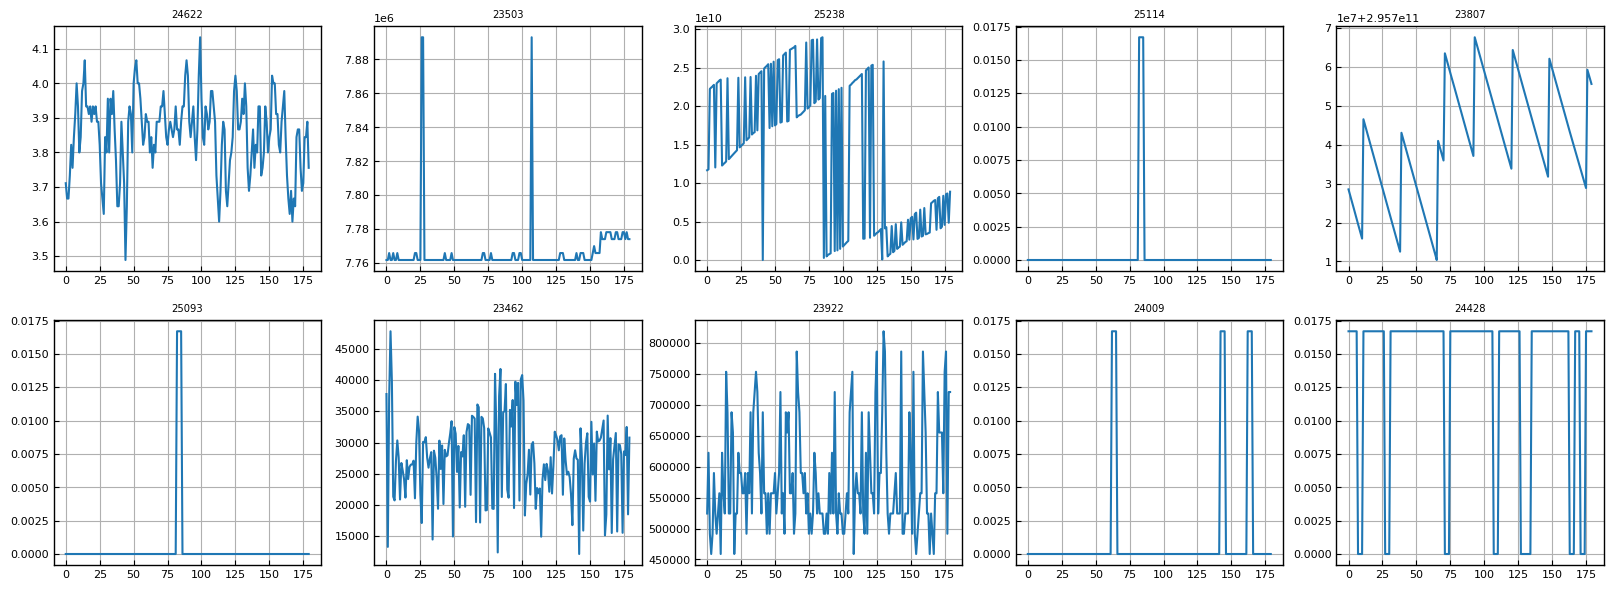

In [334]:
## plot the time series
fig, axs = plt.subplots(figsize=(20, 7), nrows=2, ncols=5)
for ax, (idx, ts) in zip(axs.flatten(), tmp_testset_df.loc[:, "time_series"].items()):
    ax.set_title(idx)
    ax.plot(ts)

In [331]:
tmp_testset_np = tmp_testset_df.loc[:, "time_series"].apply(scipy.stats.zscore, axis=0).to_numpy()
tmp_testset_np

array([array([-1.2896448 , -1.69188498, -1.69188498, -1.08852472, -0.28313843,
              -0.88649869, -0.08201834,  0.52224786,  1.32763415,  0.72336795,
              -0.48425851, -0.08201834,  1.12651407,  1.32763415,  1.93190036,
               0.72336795,  0.72336795,  0.52224786,  0.72336795,  0.32112778,
               0.72336795,  0.52224786,  0.72336795,  0.32112778,  0.32112778,
              -0.28313843, -1.2896448 , -1.69188498, -2.0950311 , -0.08201834,
              -0.48425851,  0.92539398, -0.48425851,  0.92358209,  0.52224786,
               1.12651407,  0.12091364, -0.6853786 , -1.89391101, -1.89391101,
              -1.2896448 ,  0.32112778, -0.48425851, -1.2896448 , -3.30265756,
              -1.89391101,  0.32112778,  0.72336795,  0.52224786, -0.48425851,
               1.32763415,  1.72987433,  1.93190036,  1.32763415,  1.32763415,
               0.92539398,  0.32112778, -0.28313843, -0.08201834,  0.52224786,
               0.32112778,  0.32112778, -0.48425851,

In [332]:
labels = knn_model.predict(tmp_testset_np)
labels

array([['Single dip', 'anomaly_outside_fault'],
       ['Multiple spikes', 'anomaly_during_fault'],
       ['Other normal', 'no_anomaly'],
       ['Single spike', 'anomaly_outside_fault'],
       ['Other normal', 'no_anomaly'],
       ['Single spike', 'anomaly_outside_fault'],
       ['Single dip', 'anomaly_during_fault'],
       ['White noise', 'no_anomaly'],
       ['Multiple spikes', 'anomaly_outside_fault'],
       ['White noise', 'no_anomaly']], dtype=object)

In [ ]:
tmp_testset_df.loc[:, ["anomaly_pattern", "anomaly_position"]] = labels
tmp_testset_df

## Active Learning for entire datasets

In [ ]:
from dataclasses import dataclass

from IPython.display import HTML


NUM_ITEMS_BY_PAGE: int = 20
NUM_FAULT_DATAPOINTS: int = (60 // 15) * 5  # 15 sec sampling to 5min

@dataclass(frozen=True)
class TSWindowForAL:
    num_total_patterns: int
    num_current_patterns: int
    anomaly_pattern_name: str
    anomaly_position_name: str
    num_total_metrics_in_current_pattern: int
    num_current_metrics_in_current_pattern: int
    metrics_df_in_current_page: pd.DataFrame
    
    def title_as_html(self) -> HTML:
        return HTML(f"<h3>Category: {self.anomaly_pattern_name}/{self.anomaly_position_name} - {self.num_current_patterns}/{self.num_total_patterns}</h3>")

    def msg_for_current_page(self) -> str:
        return f"Showing {self.num_current_metrics_in_current_pattern} of {self.num_total_metrics_in_current_pattern} metrics in the current pattern"
    
    def plots(self, axs) -> None:
        for ax in axs.flatten():
            ax.clear()
        for i, (ax, item) in enumerate(zip(axs.flatten(), self.metrics_df_in_current_page.itertuples())):
            ax.plot(item.time_series)
            ax.set_title(
                f"{i+1}: {item.Index} - {item.chaos_type}/{item.chaos_comp}/{item.metric}"
            )
            ax.axvspan(
                item.time_series.size - NUM_FAULT_DATAPOINTS,
                item.time_series.size, 
                color='red', alpha=0.5,
            )

In [ ]:
import math

def create_widget_for_active_learning(yield_on_click, num_items_by_page: int = NUM_ITEMS_BY_PAGE) -> widgets.Box:
    all_correct_button = widgets.Button(description='All correct')
    incorrect_items_selector = widgets.SelectMultiple(
        options=[],
        rows=num_items_by_page+2,
        disabled=False,
        layout=widgets.Layout(width='40%'),
    )
    title_output = widgets.Output(layout={'border': '1px solid black'})
    msg_output = widgets.Output(layout={'border': '1px solid black'})
    fig_output = widgets.Output(layout={'border': '1px solid black'})

    plt.rcParams["font.size"] = 6
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    fig, axs = plt.subplots(
        nrows=num_items_by_page//5,
        ncols=5,
        figsize=(35, 3.0 * math.ceil(num_items_by_page / 5)),
        clear=True,
    )

    def show(tsw: TSWindowForAL) -> None:
        with title_output:
            title_output.clear_output(wait=True)
            display(tsw.title_as_html())
        with msg_output:
            msg_output.clear_output(wait=True)
            display(tsw.msg_for_current_page())

        tsw.plots(axs)
        with fig_output:
            fig_output.clear_output(wait=True)
            display(fig)
        
        incorrect_items_selector.options = tsw.metrics_df_in_current_page.index.tolist()

    def on_all_correct_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindowForAL = yield_on_click.send((incorrect_items_selector.value))
        show(tsw)

    all_correct_button.on_click(on_all_correct_click_callback)
    plt.close(fig=fig)
    show(next(yield_on_click))

    return widgets.VBox([
        title_output,
        msg_output,
        fig_output,
        all_correct_button,
        incorrect_items_selector,
    ])

In [ ]:
import datetime
from collections import defaultdict
import pathlib

import jsonlines

SAVE_DIR = pathlib.Path("../samples/tsdr_anomaly_patterns")

def generator_for_manual_batch_confirmation(
    predicted_df: pd.DataFrame,
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
):
    save_file_path: pathlib.Path = SAVE_DIR / f"mislabeled_tsdr_anomaly_patterns_{time}.jsonl"

    grped_predicted_df = predicted_df.groupby(["anomaly_pattern", "anomaly_position"])
    for i, ((apattern, aposition), grped_df) in enumerate(grped_predicted_df):
        for j in range(0, grped_df.shape[0], NUM_ITEMS_BY_PAGE):
            # make pager
            predicted_df_by_page: pd.DataFrame = grped_df.iloc[j:j+NUM_ITEMS_BY_PAGE]
            tsw = TSWindowForAL(
                num_total_patterns=len(grped_predicted_df),
                num_current_patterns=i+1,
                num_total_metrics_in_current_pattern=grped_df.shape[0],
                num_current_metrics_in_current_pattern=j+1,
                anomaly_pattern_name=apattern,
                anomaly_position_name=aposition,
                metrics_df_in_current_page=predicted_df_by_page,
            )

            # Sent tsw to the UI widget's callback
            (mislabeled_df_index) = (yield tsw)

            with jsonlines.open(str(save_file_path), mode='a', flush=True) as writer:
                for mislabeled_idx in mislabeled_df_index:
                    mislabeled_df = predicted_df_by_page.loc[mislabeled_idx, :]
                    writer.write({
                        "dataset_id": DATASET_ID, 
                        "target_app": mislabeled_df["target_app"], 
                        "chaos_type": mislabeled_df["chaos_type"],
                        "chaos_comp": mislabeled_df["chaos_comp"],
                        "metric": mislabeled_df["metric"],
                        "time_series": mislabeled_df["time_series"].tolist(),
                        "mislabeled_anomaly_pattern": apattern,
                        "mislabeled_anomaly_position": aposition,
                    })

In [ ]:
predicted_df: pd.DataFrame = predict_anomaly_patterns(
    [well_injected_fault_datasets[0]], learn_anomaly_patterns_with_knn(train_X_df, k=1),
)

In [ ]:
box = create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(predicted_df)
)
display(box)